# 1. Setup and Initialization
## Objective
Initialize the environment, import necessary libraries, and define global hyperparameters.

## Key Hyperparameters
* **IMG_SIZE**: (224, 224) - Standard input size for models like ResNet/VGG.
* **BATCH_SIZE**: 32 - Number of images processed before updating weights. Larger batches need more VRAM.
* **EPOCHS**: 30 - Maximum number of times the model will see the entire dataset.

In [1]:
train_path = "/mnt/d/01_Projects/CV/Eye Project/data_split/train"
test_path = "/mnt/d/01_Projects/CV/Eye Project/data_split/test"
val_path = "/mnt/d/01_Projects/CV/Eye Project/data_split/val"

In [2]:
import os
print(os.listdir(train_path))

['close_look', 'forward_look', 'left_look', 'right_look']


# 2.1 Visualization: Raw Data Check
## Objective
Before training, we must visualize a random batch of images to ensure:
1.  **Path Correctness:** The code is finding the files.
2.  **Label Correctness:** (Optional) Verify the images match their folder names.
3.  **Image Quality:** Check if resizing to (128x128) destroys important details.

## Method
* We create a temporary `ImageDataGenerator` with **no augmentation**.
* We use `next()` to grab a single batch of 8 images.
* We use `matplotlib` to plot them in a 2x4 grid.

2026-02-11 01:45:22.138349: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 10049 images belonging to 4 classes.


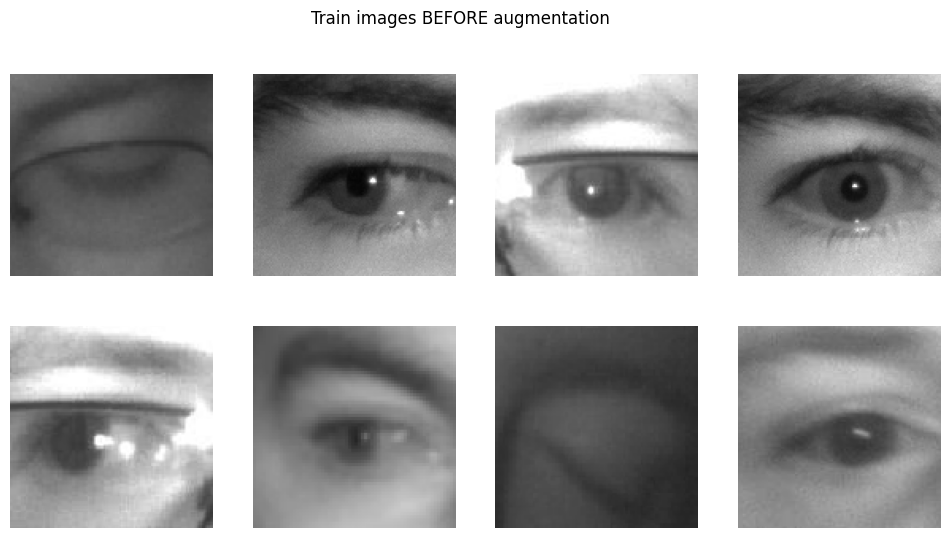

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Simple ImageDataGenerator for visualization (no augmentation)
visual_datagen = ImageDataGenerator(rescale=1./255)
visual_generator = visual_datagen.flow_from_directory(
    train_path,
    target_size=(128,128),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)

# Get one batch of images
images, labels = next(visual_generator)

# Plot images
plt.figure(figsize=(12,6))
for i in range(len(images)):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.suptitle("Train images BEFORE augmentation")
plt.show()

# Histogram Equalization And Data Augmentation

Histogram Equalization (HE):
Histogram Equalization is a technique used to enhance the contrast of an image by redistributing the intensity values of pixels.

It spreads out the most frequent intensity values over the entire range (0–255 for 8-bit images).

This improves the visibility of details, especially in images that are too dark or too bright.

However, applying standard HE globally can sometimes over-amplify noise and distort local details.

Contrast Limited Adaptive Histogram Equalization (CLAHE):

CLAHE is an advanced version of histogram equalization that works locally on small regions (tiles) of the image instead of the whole image.


Each tile has its histogram equalized independently.

The "Contrast Limited" feature prevents over-amplification of noise by limiting the contrast.

CLAHE is particularly useful for images where local contrast enhancement is needed, such as medical images, eye images, or low-light images.

Benefits of using CLAHE:

* Enhances local features and details without affecting the entire image globally.

* Reduces the effect of lighting variations.

* Improves performance in computer vision tasks, such as feature extraction or image classification.

# 2.2 Preprocessing Helper: CLAHE
## Purpose
To handle inconsistent lighting (shadows, over-exposure), we use **CLAHE** (Contrast Limited Adaptive Histogram Equalization).

## The Logic
1.  **Grid processing:** The image is divided into 8x8 tiles.
2.  **Local Equalization:** Contrast is improved inside each tile, preserving local details like eyelashes or iris texture.
3.  **Dimension Fix:** We convert the 2D Grayscale image `(H, W)` to a 3D Tensor `(H, W, 1)` because CNN layers expect a channel dimension.

In [5]:
import cv2

In [9]:
def equalize(img):
  img = img.astype("uint8")
  clahe = cv2.createCLAHE(tileGridSize=(8,8))
  img = clahe.apply(img)
  img = np.expand_dims(img, 2)  # This uses NumPy to add a new axis to the image img at position 2.(height, width, 1),
  # Because the NN in The CNN expect the size of (H, W, channel)
  img = img.astype("float32") # Convert the int8 to float 32 because in the ImageDataGen it can't scale the data that have type int8
  return img

Convert the image to uint8 format to ensure compatibility with image processing functions, Set up the CLAHE algorithm with a grid size of ** 8x8 ** tiles, and Apply CLAHE to enhance the contrast of the image.

In [10]:
def compare_equalized(img_path):
    # Read the image from the given file path using OpenCV
    img = cv2.imread(img_path)

    # Resize the image to 128x128 pixels
    # This ensures a fixed size for display or input to a CNN
    img = cv2.resize(img, (128, 128))

    # Convert the image from BGR (OpenCV default) to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply the equalization function (CLAHE) to enhance contrast
    # .squeeze() removes the extra dimension added in equalize (H, W, 1) → (H, W)
    img2 = equalize(img).squeeze()

    # Stack the original grayscale and equalized images horizontally
    # This creates a side-by-side comparison
    img2 = np.hstack([img, img2])

    # Display the combined image using matplotlib
    # cmap="gray" ensures it is displayed as a grayscale image
    plt.imshow(img2, cmap="gray")
    plt.show()  # Show the plot


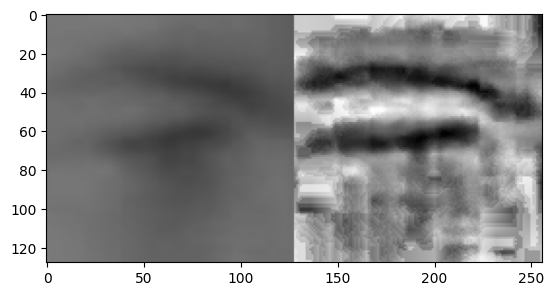

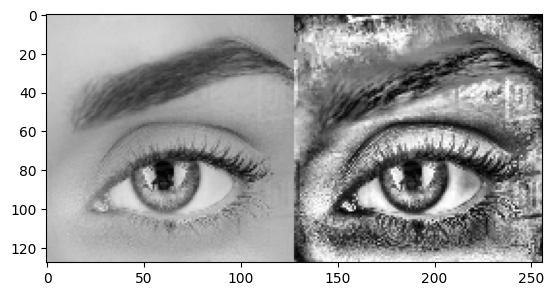

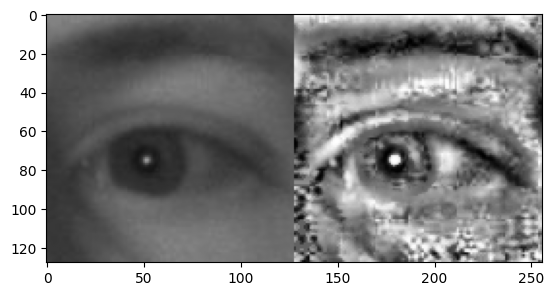

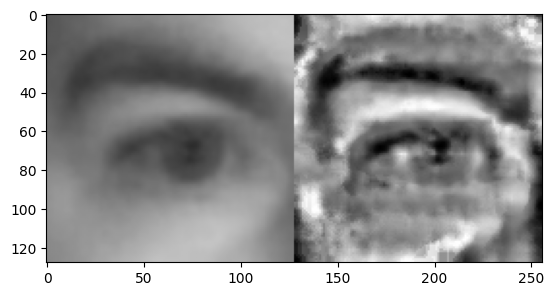

In [12]:
# Import cv2
import cv2
compare_equalized("/mnt/d/01_Projects/CV/Eye Project/data_split/train/close_look/eye_closed (2).png")
compare_equalized("/mnt/d/01_Projects/CV/Eye Project/data_split/train/forward_look/forward_look (3).jpg")
compare_equalized("/mnt/d/01_Projects/CV/Eye Project/data_split/train/left_look/left_ (3).png")
compare_equalized("/mnt/d/01_Projects/CV/Eye Project/data_split/train/right_look/right_(1).jpg")

# 2. Data Preprocessing & Augmentation
## Theory
We use `ImageDataGenerator` to perform two critical tasks:
1.  **Normalization:** Scaling pixel values from [0, 255] to [0, 1] for stable training.
2.  **Augmentation (Train only):** Applying random transformations (rotation, zoom, flips) to prevent overfitting.

## The Logic
* **Train Generator:** Includes augmentation to make the model robust.
* **Val/Test Generator:** Only rescales. No distortion is applied so we can measure real-world performance accurately.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function = equalize,
    rescale = 1./255,
    rotation_range =20,
    zoom_range =0.15,
    horizontal_flip=True,
    brightness_range=(0.8,1.2)

)

test_datagen = ImageDataGenerator(preprocessing_function=equalize, rescale = 1./255)
val_datagen = ImageDataGenerator(preprocessing_function=equalize, rescale = 1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128,128),
    batch_size=16,
    class_mode="categorical",
    color_mode="grayscale"
)
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    color_mode = "grayscale"
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    color_mode = "grayscale"
)

Found 10059 images belonging to 4 classes.
Found 2152 images belonging to 4 classes.
Found 2159 images belonging to 4 classes.


In [ ]:
x,y = next(train_generator)
x.shape

(16, 128, 128, 1)

In [ ]:
y.shape

(16, 4)

In [ ]:
train_generator[0] # Access the first batch of images (X_batch, y_batch)


(array([[[[0.29803923],
          [0.20392159],
          [0.20392159],
          ...,
          [0.75294125],
          [0.8352942 ],
          [0.95294124]],
 
         [[0.45882356],
          [0.45882356],
          [0.45882356],
          ...,
          [0.75294125],
          [0.8588236 ],
          [0.95294124]],
 
         [[0.45882356],
          [0.45882356],
          [0.45882356],
          ...,
          [0.75294125],
          [0.8705883 ],
          [0.95294124]],
 
         ...,
 
         [[0.6117647 ],
          [0.6117647 ],
          [0.7568628 ],
          ...,
          [0.65882355],
          [0.65882355],
          [0.65882355]],
 
         [[0.6117647 ],
          [0.7568628 ],
          [0.7568628 ],
          ...,
          [0.65882355],
          [0.65882355],
          [0.65882355]],
 
         [[0.6117647 ],
          [0.7568628 ],
          [0.7568628 ],
          ...,
          [0.65882355],
          [0.65882355],
          [0.65882355]]],
 
 
        [

In [ ]:
train_generator[0][0] # Access the Images part of (X_batch)
# X_batch has shape (batch_size, h, w, channels)

array([[[[0.9921569 ],
         [0.92549026],
         [0.8745099 ],
         ...,
         [0.627451  ],
         [0.627451  ],
         [0.627451  ]],

        [[0.9921569 ],
         [0.9921569 ],
         [0.90196085],
         ...,
         [0.5529412 ],
         [0.5529412 ],
         [0.5529412 ]],

        [[0.9921569 ],
         [0.9921569 ],
         [0.90196085],
         ...,
         [0.5529412 ],
         [0.5529412 ],
         [0.5529412 ]],

        ...,

        [[0.95294124],
         [0.95294124],
         [0.95294124],
         ...,
         [0.45098042],
         [0.45098042],
         [0.45098042]],

        [[0.8705883 ],
         [0.8705883 ],
         [0.8705883 ],
         ...,
         [0.45098042],
         [0.45098042],
         [0.45098042]],

        [[0.7372549 ],
         [0.7372549 ],
         [0.7372549 ],
         ...,
         [0.5176471 ],
         [0.45098042],
         [0.45098042]]],


       [[[0.9725491 ],
         [0.9725491 ],
         [0.97

In [ ]:
train_generator[0][0][0].shape

(128, 128, 1)

In [ ]:
train_generator.class_indices


{'close_look': 0, 'forward_look': 1, 'left_look': 2, 'right_look': 3}

# Visualize some Images after augmentaion

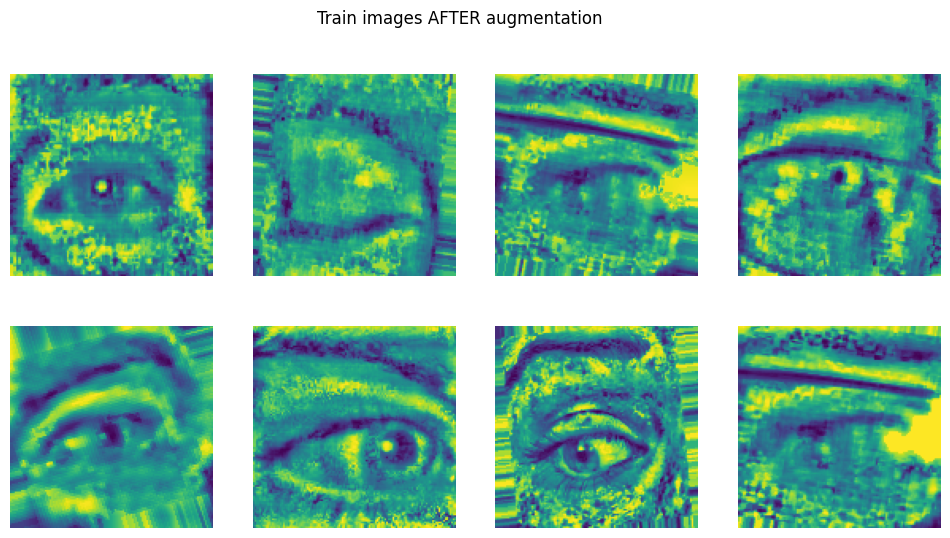

In [ ]:
# Take one batch from augmented train_generator
aug_images, aug_labels = next(train_generator)

plt.figure(figsize=(12,6))
for i in range(min(len(aug_images), 8)): # Limit to 8 images for 2x4 subplot
    plt.subplot(2,4,i+1)
    plt.imshow(aug_images[i])
    plt.axis('off')
plt.suptitle("Train images AFTER augmentation")
plt.show()

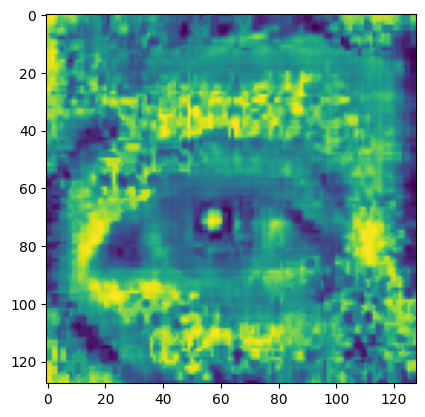

In [ ]:
plt.imshow(aug_images[0])

In [ ]:
import cv2
img_path = "/content/drive/MyDrive/Colab_Notebooks/NTI DL for CV/Eye Project/Data/data_split/train/forward_look/forward_look (100).jpg"

img = cv2.imread(img_path)
img.shape

(404, 497, 3)

# Build the CNN Model (1)

# 3. Model Architecture (CNN)
## Architecture Breakdown
We build a Sequential Convolutional Neural Network (CNN) with the following blocks:

1.  **Convolutional Block:**
    * `Conv2D`: Extracts spatial features (edges, textures).
    * `ReLU`: Adds non-linearity.
    * `MaxPooling2D`: Reduces dimensionality and computation.
2.  **Classifier Head:**
    * `Flatten`: Converts 2D feature maps to a 1D vector.
    * `Dense (Hidden)`: Learns combinations of features.
    * `Dense (Output)`: Final classification using **Softmax** (for multi-class) or **Sigmoid** (for binary).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical
 # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Activation,GlobalAveragePooling2D
from keras.optimizers import RMSprop, Adam, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


sns.set(style='white', context='notebook', palette='deep')

In [ ]:
model = Sequential()
#####################Feature Extraction##########################
# first layer
model.add(Conv2D(filters = 16, kernel_size =(3,3), padding = "Same", input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
# second
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="Same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Third
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="Same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# # Forth
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="Same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

########################End Feature Extraction######################3

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(4, activation="softmax"))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 125,988 (492.14 KB)

 Trainable params: 125,060 (488.52 KB)

 Non-trainable params: 928 (3.62 KB)

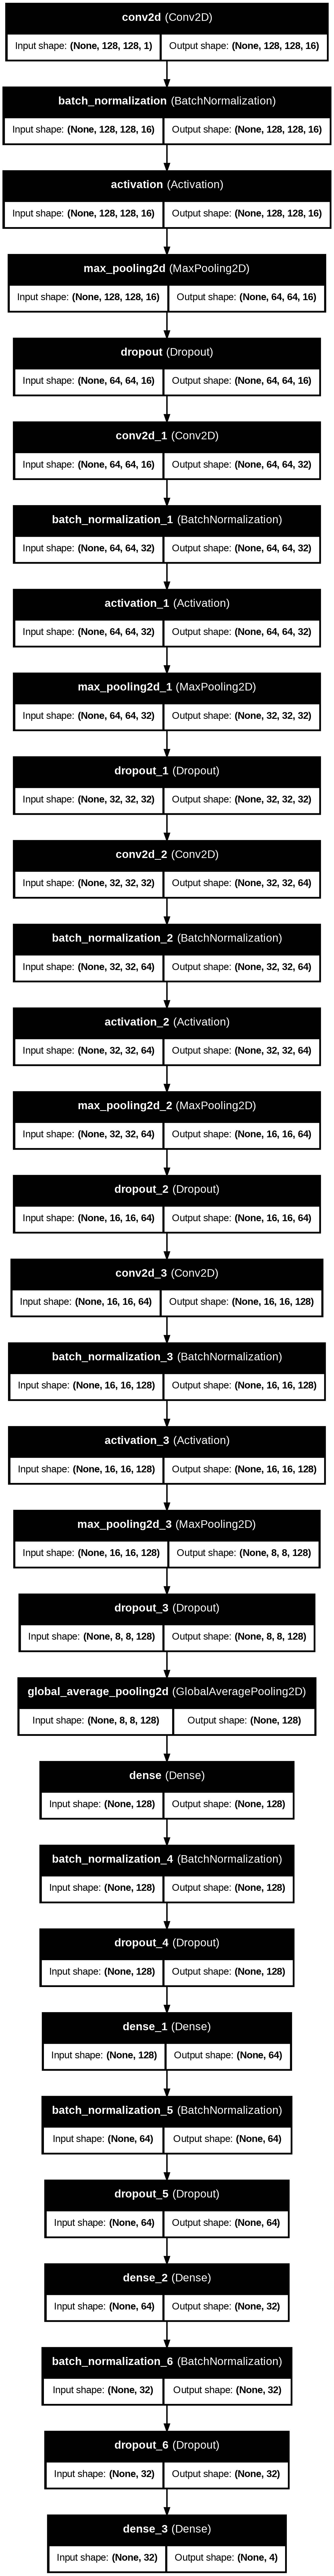

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="/content/drive/MyDrive/Colab_Notebooks/NTI DL for CV/Eye Project/plots/CNN_plot.png", show_shapes=True, show_layer_names=True)

# Compiling

# 4. Training Configuration & Callbacks
## Compiler Settings
* **Optimizer:** Adam (Adaptive learning rate, standard for vision).
* **Loss Function:** `categorical_crossentropy` (since classes are one-hot encoded).

## Callbacks (Safety Nets)
1.  **EarlyStopping:** Stops training if `val_loss` doesn't improve for 5 epochs. Prevents overfitting.
2.  **ModelCheckpoint:** Saves the *best* version of the model, not just the final one.
3.  **ReduceLROnPlateau:** Reduces learning rate by factor of 0.2 if validation accuracy stagnates.

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(
    learning_rate=0.0005,  # slightly lower than default for stable training
    beta_1=0.9,            # default, usually leave as is
    beta_2=0.999,          # default, usually leave as is
    epsilon=1e-08,         # slightly lower than default, good for numerical stability
    amsgrad=False           # optional, True can help in some cases
)

In [ ]:
# Using the F1 score as metric for compiling
# !pip install tensorflow-addons
# import tensorflow_addons as tfa

# f1 = tfa.metrics.F1Score(num_classes=num_classes, average='macro')


In [ ]:
from tensorflow import keras

In [ ]:
!pip install tensorflow-addons


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [ ]:
# from tensorflow.keras.metrics import F1Score # Uncomment if F1Score is available and you want to add it

model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy",
                       keras.metrics.Recall(name="recall"),
                       keras.metrics.Precision(name="precision"),
                       keras.metrics.F1Score(average='macro', name='f1_score') # Using F1Score from tf.keras.metrics
                      ])

# Callbacks

In [ ]:
#save_model = "/content/drive/MyDrive/Colab_Notebooks/NTI DL for CV/Eye Project/Models"
#os.makedirs(save_model, exist_ok = True)


In [ ]:
#checkpoint_path = os.path.join(save_model, "CNN_tuned.keras")


In [ ]:
#checkpoint_path

'/content/drive/MyDrive/Colab_Notebooks/NTI DL for CV/Eye Project/Models/CNN_min_loss.keras'

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# rl = ReduceLROnPlateau(monitor="val_accuracy",
#                        patience=5,
#                        verbose=1,
#                        factor=0.3,
#                        min_lr=0.00001)

# early_stopping = EarlyStopping(monitor="val_accuracy",
#                                patience=6,
#                                verbose=1,
#                                mode="max")

# checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy",verbose=1, save_best_only=True, mode="max")

In [ ]:
def get_callbacks(model_name):
  callbacks = []
  rl = ReduceLROnPlateau(monitor="val_accuracy",
                         patience=5,
                         verbose=1,
                         factor=0.5,
                         min_lr=0.00001)
  callbacks.append(rl)
  early_stopping = EarlyStopping(monitor="val_accuracy",
                                 patience=6,
                                 verbose=1,
                                 mode="max")

  callbacks.append(early_stopping)
  checkpoint = ModelCheckpoint(monitor= "val_accuracy",mode="max",patience=10)
  callbacks.append(checkpoint)

  return callb

# Fit the Model

In [ ]:
history = model.fit(
    train_generator,                     # ✅ Training data generator
                                         # This yields batches of images and labels from your training folder.
                                         # It handles data augmentation and preprocessing automatically.

    validation_data=val_generator,       # ✅ Validation data generator
                                         # Keras evaluates this data at the end of each epoch to monitor
                                         # the model's generalization (not just training performance).

    epochs=20,                           # ✅ Number of epochs
                                         # The model will iterate 50 times over the entire training data.

    callbacks=[rl, early_stopping, checkpoint],
                                         # ✅ Callbacks
                                         # rl = ReduceLROnPlateau: reduces learning rate if val_loss stops improving
                                         # early_stopping = stops training early if val_loss doesn't improve for patience epochs
                                         # checkpoint = saves the best model (highest val_accuracy or lowest val_loss)

    # steps_per_epoch=len(train_generator),
                                         # ✅ Steps per epoch
                                         # Number of batches of images to process in one epoch.
                                         # len(train_generator) already gives the number of batches in the training set.
                                         # One epoch = going through all batches once.

    # validation_steps=len(val_generator),
                                         # ✅ Validation steps
                                         # Number of batches to process from the validation set at the end of each epoch.
                                         # len(val_generator) = number of batches in validation set.

    verbose=1                             # ✅ Verbosity
                                         # 0 = silent, 1 = progress bar, 2 = one line per epoch.
                                         # Here, verbose=1 shows a progress bar and metrics for each epoch.
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3660 - f1_score: 0.3603 - loss: 1.5312 - precision: 0.4063 - recall: 0.2275
Epoch 1: val_accuracy improved from -inf to 0.32063, saving model to /content/drive/MyDrive/Colab_Notebooks/NTI DL for CV/Eye Project/Models/CNN_tuned.keras
629/629 ━━━━━━━━━━━━━━━━━━━━ 7350s 12s/step - accuracy: 0.3660 - f1_score: 0.3604 - loss: 1.5309 - precision: 0.4065 - recall: 0.2276 - val_accuracy: 0.3206 - val_f1_score: 0.1904 - val_loss: 3.1641 - val_precision: 0.3359 - val_recall: 0.3044 - learning_rate: 5.0000e-04
Epoch 2/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.4872 - f1_score: 0.4695 - loss: 1.0937 - precision: 0.6243 - recall: 0.3006
Epoch 2: val_accuracy did not improve from 0.32063
629/629 ━━━━━━━━━━━━━━━━━━━━ 372s 591ms/step - accuracy: 0.4872 - f1_score: 0.4695 - loss: 1.0936 - precision: 0.6243 - recall: 0.3006 - val_accuracy: 0.3174 - val_f1_score: 0.1880 - val_loss: 5.0938 - val_precision: 0.3198 - val_reca

# Load the best model and increase the number of epochs

In [ ]:
from keras.models import load_model
CNN_model = load_model(checkpoint_path)


In [ ]:
history2 = CNN_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[rl, early_stopping, checkpoint],
    verbose=1
)

Epoch 1/30
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7835 - loss: 0.4649
Epoch 1: val_accuracy did not improve from 0.82621
629/629 ━━━━━━━━━━━━━━━━━━━━ 342s 539ms/step - accuracy: 0.7835 - loss: 0.4649 - val_accuracy: 0.7528 - val_loss: 0.4922 - learning_rate: 5.0000e-04
Epoch 2/30
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.7777 - loss: 0.4567
Epoch 2: val_accuracy did not improve from 0.82621
629/629 ━━━━━━━━━━━━━━━━━━━━ 342s 543ms/step - accuracy: 0.7777 - loss: 0.4567 - val_accuracy: 0.7756 - val_loss: 0.3884 - learning_rate: 5.0000e-04
Epoch 3/30
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7719 - loss: 0.4534
Epoch 3: val_accuracy did not improve from 0.82621
629/629 ━━━━━━━━━━━━━━━━━━━━ 337s 536ms/step - accuracy: 0.7719 - loss: 0.4534 - val_accuracy: 0.7797 - val_loss: 0.4477 - learning_rate: 5.0000e-04
Epoch 4/30
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.7886 - loss: 0.4329
Epoch 4: val_accuracy did not improve from 0.826

# 5. Model Evaluation
## Metrics
* **Accuracy/Loss Curves:** Visual check for overfitting (large gap between train/val lines).
* **Confusion Matrix:** Identifies specific classes the model confuses.
* **Classification Report:** Provides Precision, Recall, and F1-Score for each class.